You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$p(clear \ tomorrow| \ cloudy \ today) = 0.5$

which means that $p(cloudy \ today| \ cloudy \ tomorrow) = 0.5$

We also have $p(cloudy \ tomorrow| \ clear \ today) = 0.1$

which means that $p(clear \ tomorrow| \ clear \ today) = 0.5$

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree.
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at $p(clear) = 0.83$ and $p(cloudy) = 0.17$.

You get the same answer for day $N$ as day $N + 1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a MARKOV CHAIN.

**Tasks**:
- Start off on a cloud day.
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N > 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a trace-plot, showing how our estimate of $p(clear)$ evolves as the chain samples.
- Prepare a histogram of the above plot. This reveals the distribution of $p(clear)$ .
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important**:
- In MCMC the process must be stationary which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a burn-in phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but you should always start with a traceplot of your samples!

**Tasks**
- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization.hist
from astroML import stats as astroMLstats

In [74]:
def prevision(x, today, p_cloudy_from_cloudy, p_cloudy_from_clear):
    if today == 0: #today cloudy
        if x < p_cloudy_from_cloudy:
            return 0
        else: 
            return 1
    if today == 1: #today clear
        if x < p_cloudy_from_clear:
            return 0
        else: 
            return 1

In [75]:
# Define probality
p_cloudy_att = 0.17
p_clear_att = 0.83

p_clear_from_cloudy = 0.5
p_cloudy_from_cloudy = 0.5
p_cloudy_from_clear = 0.1
p_clear_from_clear = 0.9

cloudy = 0
clear = 1

# Number of iterations
N = int(1e4)

In [76]:
# Define starting condition
today = cloudy

# Inizialize the Markov Chain
days = np.array([])
days = np.append(days, today)

p_clear = []
p_cloudy = []

for i in range(1, N+1):
    #print(i, T[i-1])
    x = np.random.uniform(0, 1)
    #print(x)
    tomorrow = prevision(x, days[i-1], p_cloudy_from_cloudy, p_cloudy_from_clear)
    #print(tomorrow)
    days = np.append(days, tomorrow)
    #print(T)

    # Probability for each day
    p_clear = np.append(p_clear, np.count_nonzero(days == 1) / (i + 1))
    p_cloudy = np.append(p_cloudy, np.count_nonzero(days == 0) / (i + 1))

print("Cloudy day: " + str(np.count_nonzero(days == 0)))
print("Clear day: " + str(np.count_nonzero(days == 1)))

print(f"Total Probability of cloudy day: {np.count_nonzero(days == 0) / len(days):.3f}")
print(f"Total Probability of clear day: {np.count_nonzero(days == 1) / len(days):.3f}")

Cloudy day: 1709
Clear day: 8292
Total Probability of cloudy day: 0.171
Total Probability of clear day: 0.829


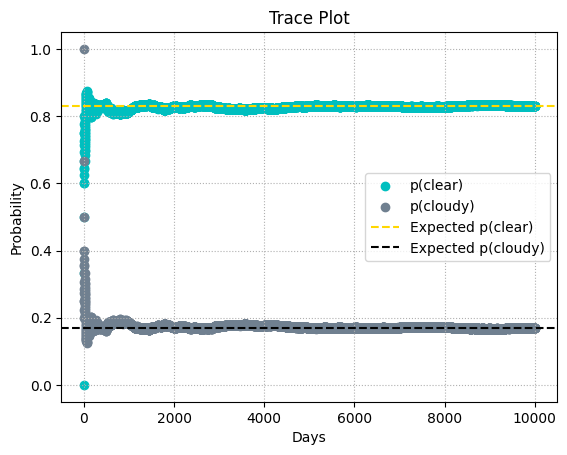

In [77]:
# Trace plot
N_days = np.linspace(0, N, N)

plt.scatter(N_days, p_clear, color = 'c', label = 'p(clear)')
plt.scatter(N_days, p_cloudy, color = 'slategray', label = 'p(cloudy)')
plt.axhline(p_clear_att, color = 'gold', linestyle = '--', label = 'Expected p(clear)')
plt.axhline(p_cloudy_att, color = 'black', linestyle = '--', label = 'Expected p(cloudy)')
plt.title('Trace Plot')
plt.xlabel('Days')
plt.ylabel('Probability')
plt.legend()
plt.grid(linestyle = ':')
plt.show()

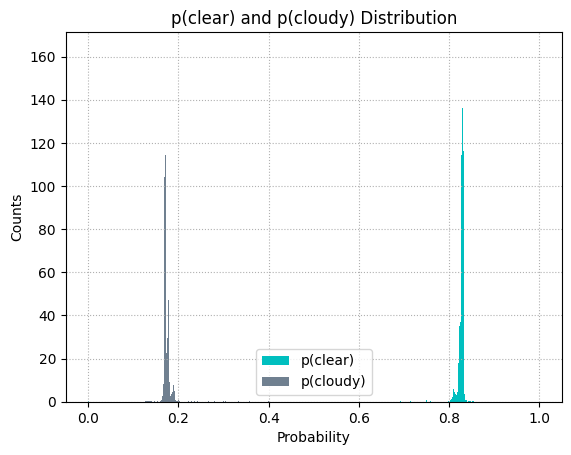

In [78]:
# Histogram
astropy.visualization.hist(p_clear, bins='freedman', density=True, color='c', label = 'p(clear)')
astropy.visualization.hist(p_cloudy, bins='freedman', density=True, color='slategray', label = 'p(cloudy)')
plt.title('p(clear) and p(cloudy) Distribution')
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.legend()
plt.grid(linestyle=':')
plt.show()

In [79]:
# Most likely value
values_clear, counts_clear = np.unique(p_clear, return_counts=True)
mode_clear = values_clear[np.argmax(counts_clear)]

values_cloudy, counts_cloudy = np.unique(p_cloudy, return_counts=True)
mode_cloudy = values_cloudy[np.argmax(counts_cloudy)]

m_clear = np.median(p_clear)
err_m_clear = astroMLstats.sigmaG(p_clear)

m_cloudy = np.median(p_cloudy)
err_m_cloudy = astroMLstats.sigmaG(p_cloudy)

print(f"p(clear) Most likely value: {m_clear:.3f} ± {err_m_clear:.3f}")
print(f"p(cloudy) Most likely value: {m_cloudy:.3f} ± {err_m_cloudy:.3f}")

p(clear) Most likely value: 0.829 ± 0.004
p(cloudy) Most likely value: 0.171 ± 0.004


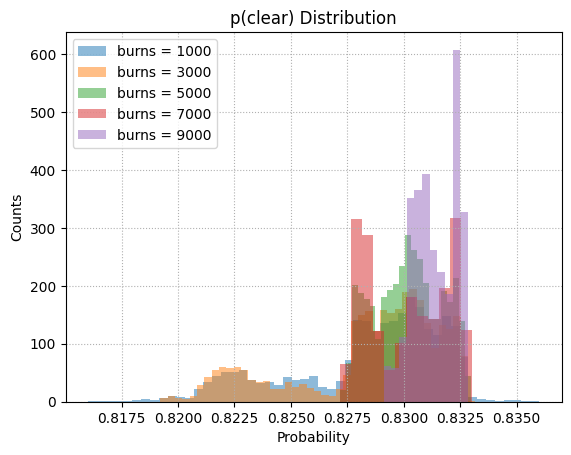

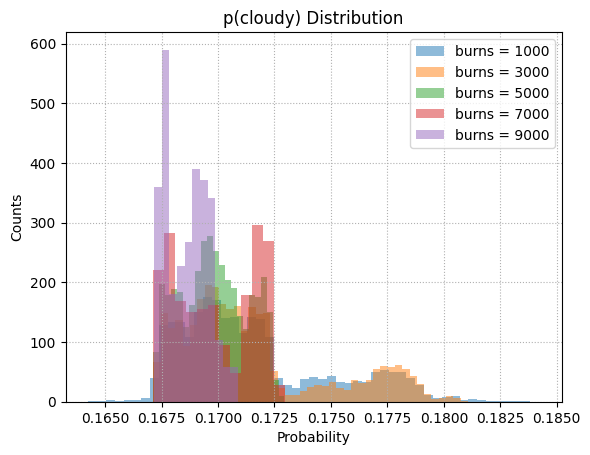

In [80]:
# Histograms with different burns
burns = np.arange(1000, 10000, 2000)

# p(clear)
for burn in burns:
    astropy.visualization.hist(p_clear[burn:], bins='freedman', density=True, alpha = 0.5, label = f'burns = {burn}')

plt.title('p(clear) Distribution')
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.legend()
plt.grid(linestyle=':')
plt.show()

# p(cloudy)
for burn in burns:
    astropy.visualization.hist(p_cloudy[burn:], bins='freedman', density=True, alpha = 0.5, label = f'burns = {burn}')

plt.title('p(cloudy) Distribution')
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.legend()
plt.grid(linestyle=':')
plt.show()
